In [1]:
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import xy
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from collections import OrderedDict
from pathlib import Path
from shapely.geometry import Point

/tmp/ipykernel_44903/2556061753.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=-112.2363281 +lat_1=35.2655015 +lat_2=41.917413 +lat_0=38.5914572 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

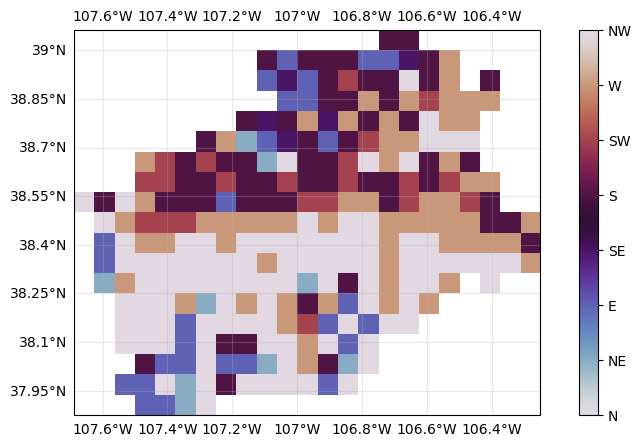

In [3]:
# read in the flow direction file
# fdr = rio.open("../data/thai_network/Thai-FDR.tif")
fdr = rio.open("../../data/colorado/basins/gunnison/ro/pars/fl.tif")
band = fdr.read(1, masked=True)

band_vicfmt = band

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


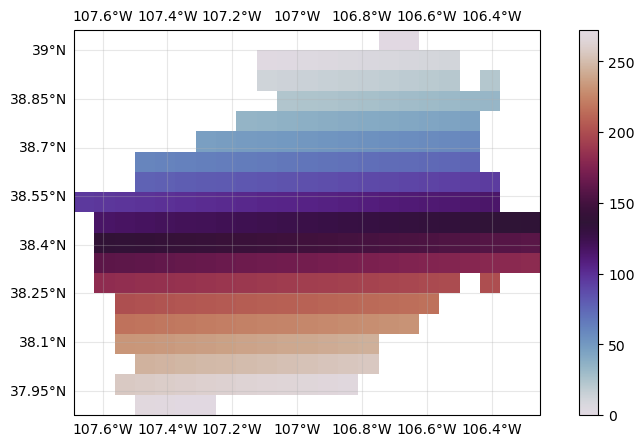

In [4]:
# create id of each cell
band_ids = np.full_like(band_vicfmt, np.nan)
_id = 0
for i in np.arange(band_vicfmt.shape[0]):
    for j in np.arange(band_vicfmt.shape[1]):
        if band_vicfmt[i][j] is not np.ma.masked:
            band_ids[i][j] = _id
            _id += 1
# band_ids = np.ma.MaskedArray(band_ids, mask=band)

band_ids
f, ax = geoax()
im = ax.imshow(band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)

<AxesSubplot:>

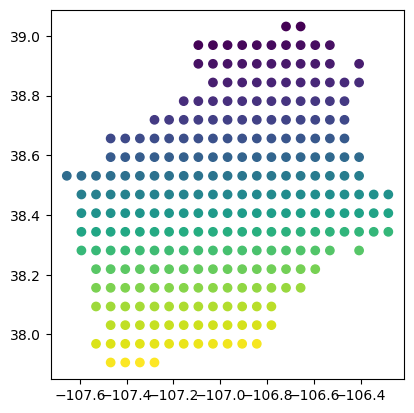

In [5]:
# create nodes
# extract x-y points
xs, _ = xy(fdr.transform, 0, np.arange(fdr.width))
_, ys = xy(fdr.transform, np.arange(fdr.height), 9)

XX, YY = np.meshgrid(xs, ys)

# create gdf
grid_pts = gpd.GeoDataFrame(data={'id': band_ids.flatten()}, geometry=[Point(x, y) for x, y in zip(XX.flatten(), YY.flatten())], crs='EPSG:4326')
grid_pts['to_id'] = np.nan

grid_pts.plot('id')

0 (0, 15) S  > | > 8 (1, 15)
1 (0, 16) S  > | > 9 (1, 16)
2 (1, 9) S  > | > 12 (2, 9)
3 (1, 10) E  > | > 4 (1, 11)
4 (1, 11) S  > | > 14 (2, 11)
5 (1, 12) S  > | > 15 (2, 12)
6 (1, 13) S  > | > 16 (2, 13)
7 (1, 14) E  > | > 8 (1, 15)
8 (1, 15) E  > | > 9 (1, 16)
9 (1, 16) SE  > | > 20 (2, 17)
10 (1, 17) S  > | > 20 (2, 17)
11 (1, 18) W  > | > 10 (1, 17)
12 (2, 9) E  > | > 13 (2, 10)
13 (2, 10) SE  > | > 24 (3, 11)
14 (2, 11) E  > | > 15 (2, 12)
15 (2, 12) S  > | > 25 (3, 12)
16 (2, 13) SW  > | > 25 (3, 12)
17 (2, 14) S  > | > 27 (3, 14)
18 (2, 15) S  > | > 28 (3, 15)
19 (2, 16) N  > | > 9 (1, 16)
20 (2, 17) S  > | > 30 (3, 17)
21 (2, 18) W  > | > 20 (2, 17)
22 (2, 20) S  > | > 33 (3, 20)
23 (3, 10) E  > | > 24 (3, 11)
24 (3, 11) E  > | > 25 (3, 12)
25 (3, 12) S  > | > 38 (4, 12)
26 (3, 13) S  > | > 39 (4, 13)
27 (3, 14) W  > | > 26 (3, 13)
28 (3, 15) S  > | > 41 (4, 15)
29 (3, 16) W  > | > 28 (3, 15)
30 (3, 17) SW  > | > 42 (4, 16)
31 (3, 18) W  > | > 30 (3, 17)
32 (3, 19) W  > | > 31 

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


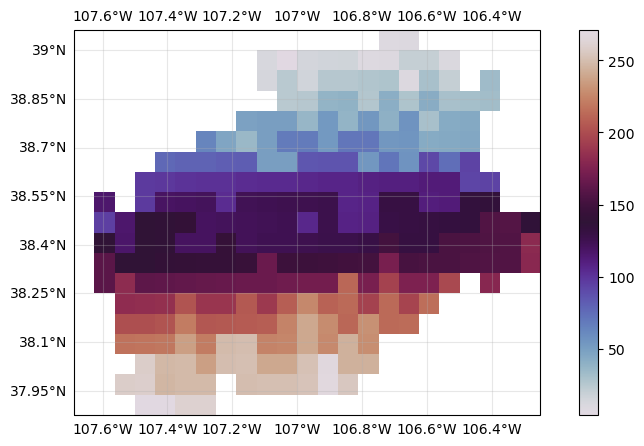

In [6]:
# create id of each cell
operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}
directions = {
    1: "N",
    2: "NE",
    3: "E",
    4: "SE",
    5: "S",
    6: "SW",
    7: "W",
    8: "NW"
}

to_band_ids = np.full_like(band_vicfmt, np.nan)
for x in np.arange(band_vicfmt.shape[0]):   
    for y in np.arange(band_vicfmt.shape[1]):  
        if band_vicfmt[x][y] is not np.ma.masked:
            direction = band_vicfmt[x][y]
            op = operations[direction]
            new_x, new_y = x + op[0], y + op[1]
            if new_x < band_ids.shape[0] and new_y < band_ids.shape[1]:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", band_ids[new_x, new_y], (new_x, new_y))
                to_band_ids[x, y] = band_ids[new_x, new_y]
            else:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", np.nan, (new_x, new_y))
                to_band_ids[x, y] = np.nan


# to_band_ids = np.ma.MaskedArray(to_band_ids, mask=band)

to_band_ids
f, ax = geoax()
im = ax.imshow(to_band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


In [7]:
grid_pts['to_id'] = to_band_ids.flatten()

grid_pts.dropna(inplace=True)

grid_pts.head()

,id,geometry,to_id
15,0.0,POINT (-106.71875 39.03126),8.0
16,1.0,POINT (-106.65625 39.03126),9.0
32,2.0,POINT (-107.09375 38.96876),12.0
33,3.0,POINT (-107.03125 38.96876),4.0
34,4.0,POINT (-106.96875 38.96876),14.0


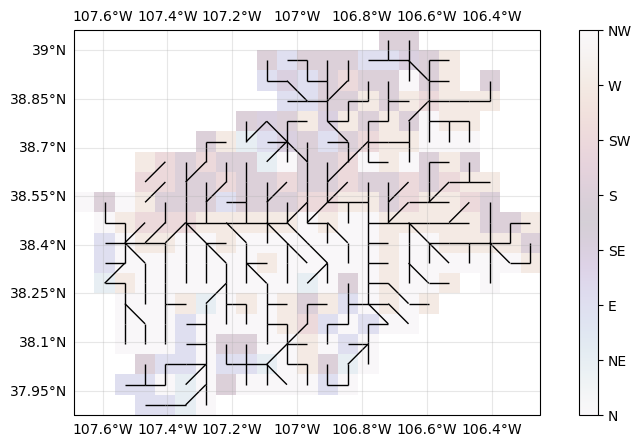

In [8]:
f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [9]:
root

id                                116.0
geometry    POINT (-107.59375 38.46876)
to_id                              95.0
Name: 208, dtype: object

Lets import the reservoir locations

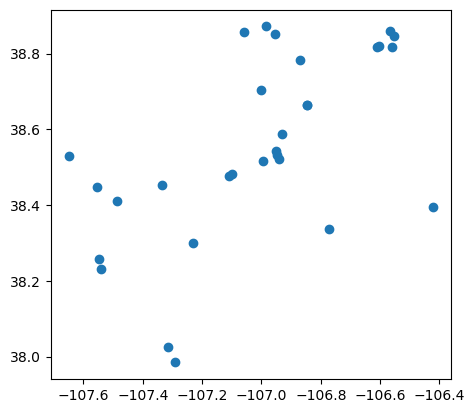

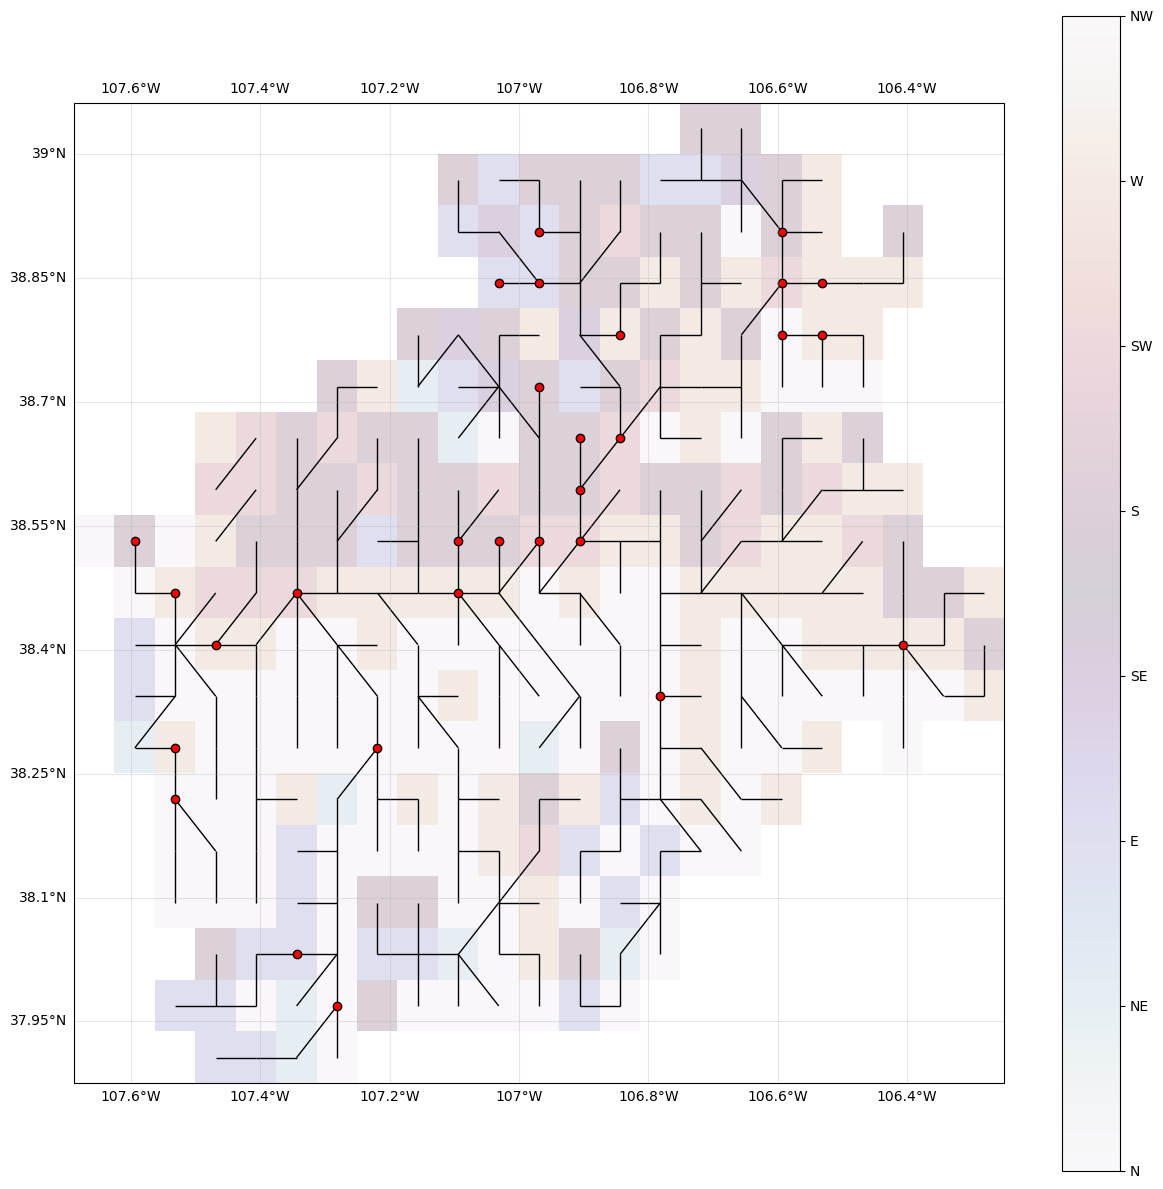

In [10]:
reservoirs_fn = "../../data/gunnison_reservoirs/gunnison_reservoirs_fdr_corrected_usgs_gages.csv"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs['geometry'] = gpd.points_from_xy(reservoirs['lon'], reservoirs['lat'])
reservoirs.set_crs('epsg:4326', inplace=True)

reservoirs_to_join = reservoirs[['name', 'lon', 'lat', 'geometry']]
reservoirs_to_join.plot()
grid_pts_joined_stns = grid_pts.to_crs(DIST_PROJ).sjoin_nearest(reservoirs_to_join.to_crs(DIST_PROJ), how='left', distance_col='dist [m]').to_crs('epsg:4326')
# grid_pts_joined_stns = grid_pts.sjoin_nearest(reservoirs_to_join, how='left', distance_col='dist [m]').to_crs('epsg:4326')

grid_pts_joined_stns['min_dist'] = grid_pts_joined_stns.groupby('name')['dist [m]'].transform('min')
grid_pts_joined_stns.loc[grid_pts_joined_stns['dist [m]'] != grid_pts_joined_stns['min_dist'], ['index_right', 'name', 'lon', 'lat', 'dist [m]', 'min_dist']] = np.nan

grid_pts_joined_stns

# plot on top of previous plot
f, ax = geoax(figsize=(15, 15))
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

grid_pts_joined_stns.dropna().plot(ax=ax, fc='red', ec='k')

gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

now we need a function that can (1) join two reservoir locations based on the network we have. (2) assign the length of travel by summing the length between the points

In [11]:
# %load_ext autoreload
# %autoreload 1
# # from regulation.regulation import *
# %aimport regulation
# Reservoir = regulation.regulation.Reservoir

In [12]:
root

id                                116.0
geometry    POINT (-107.59375 38.46876)
to_id                              95.0
Name: 208, dtype: object

In [13]:
grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)
stations = grid_pts_joined_stns.dropna()
stations

dist = lambda left_pt, right_pt: np.sqrt((left_pt.x-right_pt.x)**2 + (left_pt.y-right_pt.y)**2)

network = OrderedDict()
for i, stn in stations.iterrows():
    # r = Reservoir()
    # r.name = stn['name']
    name = stn['name']
    # r.id = stn['index_right']
    id = stn['index_right']
    length = 0
    
    if id not in network:
        network[id] = OrderedDict([
            ('network', []),
            ('lengths', [])
        ])

    current_id = stn['id']
    while True:
        current_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==current_id]
        next_id = current_node['to_id'].iloc[0]
        next_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==next_id]
        # print("\n\n\n", current_node['geometry'], next_node['geometry'])
        if len(next_node) > 0:
            length += dist(current_node['geometry'].iloc[0], next_node['geometry'].iloc[0])
        if not np.isnan(current_node['index_right'].iloc[0]):
            network[id]['network'].append(current_node['index_right'].iloc[0])
            network[id]['lengths'].append(length)


        if current_id == root['id']:
            break
        
        current_id = next_id


# in_network

In [14]:
network

OrderedDict([(10.0,
              OrderedDict([('network',
                            [10.0,
                             8.0,
                             14.0,
                             19.0,
                             16.0,
                             26.0,
                             1.0,
                             2.0,
                             24.0]),
                           ('lengths',
                            [5412.247547868701,
                             43846.05754701553,
                             50784.0042598264,
                             59602.13357890827,
                             75358.13535161022,
                             86248.68570600354,
                             111405.49514271623,
                             122305.48155842567,
                             134688.55496877077])])),
             (4.0,
              OrderedDict([('network',
                            [4.0,
                             0.0,
                       

In [15]:
# convert this network to a stream network

from shapely.geometry import LineString, Point
from itertools import pairwise

grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)

from_id = []
to_id = []
from_name = []
to_name = []
geoms = []
lengths = []

for id in network:
    downstreams = network[id]['network']
    link_lengths = network[id]['lengths']
    
    # print(downstreams, link_lengths)

    for id_pair, length in zip(pairwise(downstreams), link_lengths[1:]):  # the first element of `link_lengths` is garbage value. It is the distance of a single link
        # print(id_pair, length)
        start_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[0]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)
        end_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[1]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)

        link = LineString([Point(pt.x, pt.y) for pt in (start_res.geometry, end_res.geometry)])

        geoms.append(link)
        from_id.append(id_pair[0])
        to_id.append(id_pair[1])
        from_name.append(start_res['name'])
        to_name.append(end_res['name'])
        lengths.append(length)

    # current_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id].iloc[0]
    # pts = []
    # for downstream_res_id in downstreams:
    #     downstream_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==downstream_res_id].to_crs('epsg:4326').iloc[0]
    #     pts.append(downstream_res.geometry)

    # if len(pts) == 1:
    #     pts.append(pts[0])

    # link = LineString([Point(pt.x, pt.y) for pt in pts])
    # geoms.append(link)
    # names.append(current_res['name'])
    # ids.append(current_res.index_right)
    # lengths.append(link_lengths[-1])


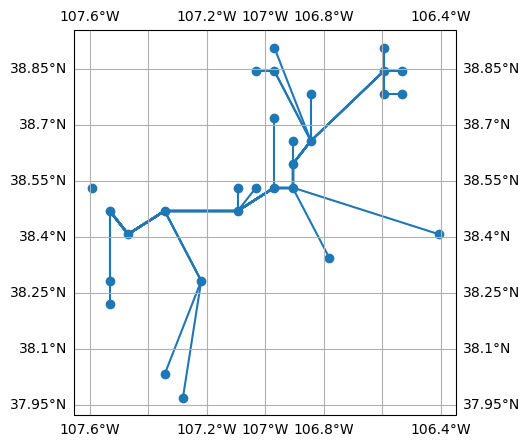

In [16]:

res_network = gpd.GeoDataFrame(data={
    'from_id': from_id,
    'to_id': to_id,
    'from_name': from_name,
    'to_name': to_name,
    'geometry': geoms,
    'length': lengths
})

f, ax = geoax()
res_network.plot(ax=ax)
grid_pts_joined_stns.dropna().to_crs('epsg:4326').plot(marker='o', ax=ax)

ax.gridlines(draw_labels=True)

In [17]:
res_network.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   from_id    152 non-null    float64 
 1   to_id      152 non-null    float64 
 2   from_name  152 non-null    object  
 3   to_name    152 non-null    object  
 4   geometry   152 non-null    geometry
 5   length     152 non-null    float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 7.2+ KB


In [18]:
# Save `res_network` for further use
save_fn = Path("../../data/gunnison_rivreg/rivreg_network.shp")  # even though .shp is not ideal, landlab uses this format to initialize. Create an issue in landlab.io?
save_fn.parent.mkdir(parents=True, exist_ok=True) # make parent directory if it doesn't exist

res_network.to_file(save_fn)

In [19]:
grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.with_name('rivreg_network_pts.shp'))

/tmp/ipykernel_44903/2206082582.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.with_name('rivreg_network_pts.shp'))
